In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from numba import jit, prange, njit
from blimpy import Waterfall
import time
import random
import datetime
from synthetic_real_dynamic import create_true, create_full_cadence, create_false, create_true_single_shot, create_true_faster
from scipy import spatial
from numpy import dot
from numpy.linalg import norm
import math
from sklearn.metrics import silhouette_score
import sys
sys.path.insert(1, '../ML_Training')
sys.path.insert(2, '../GBT_pipeline')
from preprocess_dynamic import get_data
from single_search import search_model_eval, combine
from skimage.transform import rescale, resize, downscale_local_mean
import gc
from keras.regularizers import l1, l2
from data_generation import create_data_set
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.85)

/home/pma/.local/lib/python3.6/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/pma/.local/lib/python3.6/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
plate1 = np.load('../../../../../../../datax/scratch/pma/real_filtered_HIP110750.npy')[15000:]
plate2 = np.load('../../../../../../../datax/scratch/pma/real_filtered_HIP13402.npy')[20000:]
plate3 = np.load('../../../../../../../datax/scratch/pma/real_filtered_HIP8497.npy')[20000:]
plate = np.vstack([plate1, plate2, plate3])
del plate1, plate2, plate3 
gc.collect()
print(plate.shape)

(32402, 6, 16, 2048)


In [3]:
%matplotlib inline
NUM_SAMPLES = 2
WIDTH_BIN=2048
data, false_data, true_data = create_data_set(plate, NUM_SAMPLES=NUM_SAMPLES, snr_base=20, snr_range = 10, factor=1, WIDTH_BIN=WIDTH_BIN)

Creating True
(2, 6, 16, 2048)
(2, 6, 16, 2048) (2, 6, 16, 256)
(2, 6, 16, 256)
(12, 16, 256, 1)
Creating False
(12, 6, 16, 2048) (12, 6, 16, 256)
(12, 6, 16, 256)
Creating True
(6, 6, 16, 2048) (6, 6, 16, 256)
(6, 6, 16, 256)
(6, 6, 16, 2048) (6, 6, 16, 256)
(6, 6, 16, 256)
(12, 6, 16, 256, 1)


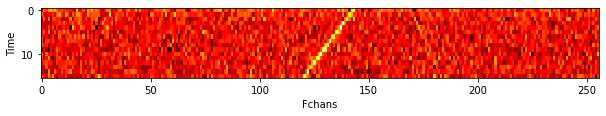

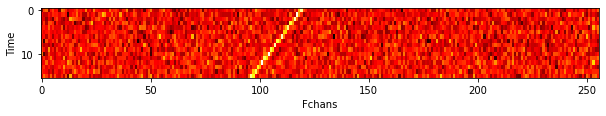

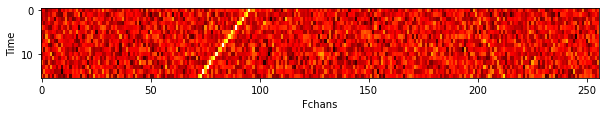

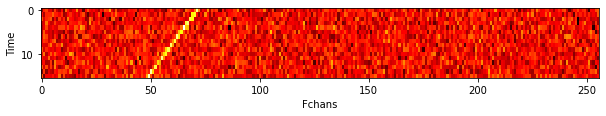

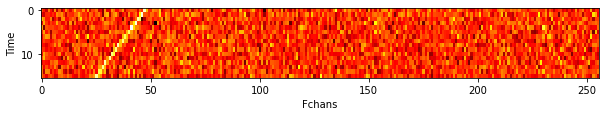

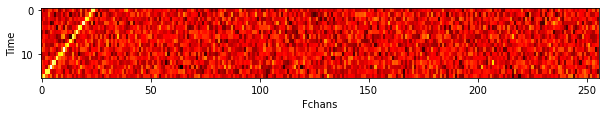

In [4]:
for i in range(6):
    plt.figure(figsize=(10,4))
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(true_data[3,i,:,:], interpolation='nearest', cmap=plt.get_cmap('hot'), aspect=2)
    plt.show()

In [5]:
NUM_SAMPLES = 2
data_test, false_data_test, true_data_test = create_data_set(plate, NUM_SAMPLES=NUM_SAMPLES, snr_base=20, snr_range = 10, factor=1, WIDTH_BIN=WIDTH_BIN)

Creating True
(2, 6, 16, 2048)
(2, 6, 16, 2048) (2, 6, 16, 256)
(2, 6, 16, 256)
(12, 16, 256, 1)
Creating False
(12, 6, 16, 2048) (12, 6, 16, 256)
(12, 6, 16, 256)
Creating True
(6, 6, 16, 2048) (6, 6, 16, 256)
(6, 6, 16, 256)
(6, 6, 16, 2048) (6, 6, 16, 256)
(6, 6, 16, 256)
(12, 6, 16, 256, 1)


In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder,alpha=10, beta=2, gamma = 10, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.true_loss_tracker = keras.metrics.Mean(name="true_loss")
        self.false_loss_tracker = keras.metrics.Mean(name="false_loss")
        
        self.true_score_tracker = keras.metrics.Mean(name="true_score")
        self.false_score_tracker = keras.metrics.Mean(name="false_score")
        
        
        self.total_loss_tracker_validation = keras.metrics.Mean(name="val_total_loss")
        self.reconstruction_loss_tracker_validation = keras.metrics.Mean(
            name="val_reconstruction_loss"
        )
        self.kl_loss_tracker_validation = keras.metrics.Mean(name="val_kl_loss")
        self.false_loss_tracker_validation = keras.metrics.Mean(name="val_false_loss")
        self.true_loss_tracker_validation = keras.metrics.Mean(name="val_true_loss")
        
        self.true_score_tracker_validation = keras.metrics.Mean(name="true_score")
        self.false_score_tracker_validation = keras.metrics.Mean(name="false_score")
        
        
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.count=1

    @tf.function
    def loss_diff(self, a,b):
        return 1/ self.loss_same(a,b)
   
    @tf.function
    def loss_same(self, a,b):
        return tf.math.reduce_mean(tf.math.reduce_euclidean_norm(a-b, axis=1))

    
    @tf.function
    def true_score(self, true_data,training=True):
        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(true_data[:,0,:,:,:], training)[2]
        b = self.encoder(true_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(true_data[:,2,:,:,:],training)[2]
        c = self.encoder(true_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(true_data[:,4,:,:,:], training)[2]
        d = self.encoder(true_data[:,5,:,:,:], training)[2]

        same+= self.loss_same(a1,a2)
        same+= self.loss_same(a1,a3)
        
        same+= self.loss_same(a2,a1)
        same+= self.loss_same(a2,a3)
        
        same+= self.loss_same(a3,a2)
        same+= self.loss_same(a3,a1)
        
        same+= self.loss_same(b,c)
        same+= self.loss_same(b,d)
        
        same+= self.loss_same(c,b)
        same+= self.loss_same(c,d)
        
        same+= self.loss_same(d,b)
        same+= self.loss_same(d,c)
        
        difference += self.loss_same(a1,b)
        difference += self.loss_same(a1,c)
        difference += self.loss_same(a1,d)
        
        difference += self.loss_same(a2,b)
        difference += self.loss_same(a2,c)
        difference += self.loss_same(a2,d)
        
        difference += self.loss_same(a3,b)
        difference += self.loss_same(a3,c)
        difference += self.loss_same(a3,d)
        
        if same > difference:
            similarity += (difference - same)/same
        else:
            similarity += (difference - same)/difference
 
        return 10*(1-similarity)/(2*(similarity+1))
    
    @tf.function
    def false_score(self, true_data,training=True):
        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(true_data[:,0,:,:,:], training)[2]
        b = self.encoder(true_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(true_data[:,2,:,:,:],training)[2]
        c = self.encoder(true_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(true_data[:,4,:,:,:], training)[2]
        d = self.encoder(true_data[:,5,:,:,:], training)[2]

        same+= self.loss_same(a1,a2)
        same+= self.loss_same(a1,a3)
        
        same+= self.loss_same(a2,a1)
        same+= self.loss_same(a2,a3)
        
        same+= self.loss_same(a3,a2)
        same+= self.loss_same(a3,a1)
        
        same+= self.loss_same(b,c)
        same+= self.loss_same(b,d)
        
        same+= self.loss_same(c,b)
        same+= self.loss_same(c,d)
        
        same+= self.loss_same(d,b)
        same+= self.loss_same(d,c)
        
        difference += self.loss_same(a1,b)
        difference += self.loss_same(a1,c)
        difference += self.loss_same(a1,d)
        
        difference += self.loss_same(a2,b)
        difference += self.loss_same(a2,c)
        difference += self.loss_same(a2,d)
        
        difference += self.loss_same(a3,b)
        difference += self.loss_same(a3,c)
        difference += self.loss_same(a3,d)
        
        if same > difference:
            similarity += -(difference - same)/same
        else:
            similarity += -(difference - same)/difference
        
        return 10*(1-similarity)/(2*(similarity+1))
    
    @tf.function
    def true_clustering(self, true_data,training=True):
        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(true_data[:,0,:,:,:], training)[2]
        b = self.encoder(true_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(true_data[:,2,:,:,:],training)[2]
        c = self.encoder(true_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(true_data[:,4,:,:,:], training)[2]
        d = self.encoder(true_data[:,5,:,:,:], training)[2]

        difference += self.loss_diff(a1,b)
        difference += self.loss_diff(a1,c)
        difference += self.loss_diff(a1,d)

        difference += self.loss_diff(a2,b)
        difference += self.loss_diff(a2,c)
        difference += self.loss_diff(a2,d)

        difference += self.loss_diff(a3,b)
        difference += self.loss_diff(a3,c)
        difference += self.loss_diff(a3,d)

        same += self.loss_same(a1,a2)
        same += self.loss_same(a1,a3)
        same += self.loss_same(a2,a3)
        
        same += self.loss_same(b,c)
        same += self.loss_same(c,d)
        same += self.loss_same(b,d)
        

        similarity += same+difference
        return similarity
    
    @tf.function
    def false_clustering(self, false_data, training=True):

        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(false_data[:,0,:,:,:], training)[2]
        b = self.encoder(false_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(false_data[:,2,:,:,:],training)[2]
        c = self.encoder(false_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(false_data[:,4,:,:,:], training)[2]
        d = self.encoder(false_data[:,5,:,:,:], training)[2]

        difference += self.loss_same(a1,b)
        difference += self.loss_same(a1,c)
        difference += self.loss_same(a1,d)

        difference += self.loss_same(a2,b)
        difference += self.loss_same(a2,c)
        difference += self.loss_same(a2,d)

        difference += self.loss_same(a3,b)
        difference += self.loss_same(a3,c)
        difference += self.loss_same(a3,d)

        same += self.loss_same(a1,a2)
        same += self.loss_same(a1,a3)
        same += self.loss_same(a2,a3)
        
        same += self.loss_same(b,c)
        same += self.loss_same(c,d)
        same += self.loss_same(b,d)
        
        similarity += same+difference
        return similarity
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self, data):
        self.count+=1
        cluster_loss =0
        x, y = data
        true_data = x[1]
        false_data = x[2]
        x= x[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(y, reconstruction), axis=(1, 2)
                )
            )/(16*256)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            false_loss = self.false_clustering(false_data)
            true_loss = self.true_clustering(true_data)
            
#             false_score = self.false_score(false_data)
#             true_score = self.true_score(true_data)
            false_score =0
            true_score = 0
            
            total_loss = reconstruction_loss/(16*256) + self.beta*kl_loss +self.alpha*(1*true_loss+false_loss)+self.gamma*(false_score+true_score)
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.false_loss_tracker.update_state(false_loss)
        self.true_loss_tracker.update_state(true_loss)
        
        self.false_score_tracker.update_state(false_score)
        self.true_score_tracker.update_state(true_score)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "false_loss": self.false_loss_tracker.result(),
            "true_loss": self.true_loss_tracker.result(),
            "false_score": self.false_score_tracker.result(),
            "true_score": self.true_score_tracker.result()
        }
    

    def test_step(self, data):
        # Unpack the data
        x, y = data
        true_data = x[1]
        false_data = x[2]
        x= x[0]
        z_mean, z_log_var, z = self.encoder(x, training=False)
        reconstruction = self.decoder(z, training=False)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(y, reconstruction), axis=(1, 2)
            )
        )/(16*256)
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        false_loss = self.false_clustering(false_data, False)
        true_loss = self.true_clustering(true_data, False)
#         false_score = self.false_score(false_data)
#         true_score = self.true_score(true_data)
        false_score = 0
        true_score =0
        total_loss = reconstruction_loss + self.beta*kl_loss +self.alpha*(1*true_loss+false_loss)+self.gamma*(false_score+true_score)
        
        
        self.total_loss_tracker_validation.update_state(total_loss)
        self.reconstruction_loss_tracker_validation.update_state(reconstruction_loss)
        self.kl_loss_tracker_validation.update_state(kl_loss)
        self.false_loss_tracker_validation.update_state(false_loss)
        self.true_loss_tracker_validation.update_state(true_loss)
        
        self.false_score_tracker_validation.update_state(false_score)
        self.true_score_tracker_validation.update_state(true_score)
        
        return {
            "loss": self.total_loss_tracker_validation.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker_validation.result(),
            "kl_loss": self.kl_loss_tracker_validation.result(),
            "false_loss": self.false_loss_tracker_validation.result(),
            "true_loss": self.true_loss_tracker_validation.result(),
            "false_score": self.false_score_tracker_validation.result(),
            "true_score": self.true_score_tracker_validation.result()
        }

In [7]:
from tensorflow.python.client import device_lib
gpus = tf.config.experimental.list_physical_devices('GPU')

In [8]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
def sample_creation(inputs):
    z_mean = inputs[0]
    z_log_var = inputs[1]
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [10]:
def build_model(latent_dim=8,dens_lay=512, kernel=(3,3), alpha=10, beta=2, gamma=10):
    
    encoder_inputs = keras.Input(shape=(16, 256, 1))
    x = layers.Conv2D(16, kernel, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(16, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(64, kernel, activation="relu", strides=2,padding="same")(x)
    x = layers.Conv2D(64, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(128, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(256, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
#     x = layers.Dropout(0.5, activity_regularizer=l1(0.001))(x)
    x = layers.Dense(dens_lay, activation="relu", activity_regularizer=l1(0.001),
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
#     x = layers.Dropout(0.5, activity_regularizer=l1(0.001))(x)
    z_mean = layers.Dense(latent_dim, name="z_mean", activity_regularizer=l1(0.001),
                          kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var" , activity_regularizer=l1(0.001),
                             kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    encoder.summary()
    
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(dens_lay, activation="relu", activity_regularizer=l1(0.001), 
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(latent_inputs)
#     x = layers.Dropout(0.5)(x)
    x = layers.Dense(1* 16 * 256, activation="relu", activity_regularizer=l1(0.001),
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
#     x = layers.Dropout(0.5)(x)
    x = layers.Reshape((1,16, 256))(x)
    x = layers.Conv2DTranspose(256, kernel, activation="relu", strides=2,padding="same")(x)
    x = layers.Conv2DTranspose(128, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(16, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(16, kernel, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, kernel, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    decoder.summary()

    vae = VAE(encoder, decoder, alpha, beta, gamma)
    vae.compile(optimizer=keras.optimizers.Adam(lr=0.001))
    return vae

strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.ReductionToOneDevice())

alpha, beta, gamma = 10,1,0
latent_dim=8
dens_lay=512
kernel=(3,3)


model_num = 54
name = "VAE-BLPC2-ENCODER_compressed_256v%d"%(model_num)
print(name)

print("Model " +name+": \(\\alpha : %3d\),  \(\\beta : %3d\),  \(\gamma : %3d\), latent_dim:%3d, dense:%3d " % (alpha, beta, gamma, latent_dim, dens_lay))

with strategy.scope():
    model = build_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
tensorflow      INFO     Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
VAE-BLPC2-ENCODER_compressed_256v54
Model VAE-BLPC2-ENCODER_compressed_256v54: \(\alpha :  10\),  \(\beta :   1\),  \(\gamma :   0\), latent_dim:  8, dense:512 
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16, 256, 1)] 0                                            
__________________________

tensorflow      INFO     Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
tensorflow      INFO     Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
tensorflow      INFO     Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
tensorflow      INFO     Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/d

In [11]:
def plot_model(history, name, i):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(15,10))

    fig.suptitle("Model v%3d: alpha:%3d, beta:%3d, gamma:%3d, latent_dim:%3d, dense:%3d " % (model_num, alpha, beta, gamma, latent_dim, dens_lay))

    ax1.plot(history.history['false_loss'])
    ax1.plot(history.history['true_loss'])
    ax1.plot(history.history['val_false_loss'])
    ax1.plot(history.history['val_true_loss'])
    ax1.set_title('Model Clustering Loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['false_loss', 'true_loss','val_false_loss','val_true_loss'], loc='upper right')
    ax1.grid()

    ax2.plot(history.history['false_score'])
    ax2.plot(history.history['true_score'])
    ax2.plot(history.history['val_false_score'])
    ax2.plot(history.history['val_true_score'])
    ax2.set_title('Model Clustering Score')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['false_score', 'true_score','val_false_score','val_true_score'], loc='upper right')
    ax2.grid()

    ax3.plot(history.history['reconstruction_loss'])
    ax3.plot(history.history['val_reconstruction_loss'])
    ax3.set_title('Model Reconstruction')
    ax3.set_ylabel('loss')
    ax3.set_xlabel('epoch')
    ax3.legend(['reconstruction_loss', 'val_reconstruction_loss'], loc='upper right')
    ax3.grid()

    ax4.plot(history.history['kl_loss'])
    ax4.plot(history.history['val_kl_loss'])
    ax4.set_title('Model Divergence')
    ax4.set_ylabel('loss')
    ax4.set_xlabel('epoch')
    ax4.legend(['kl_loss', 'val_kl_loss'], loc='upper right')
    ax4.grid()
    fig.savefig(name+"-"+str(i)+'.png')

In [ ]:
BATCH= 10
NUM_SAMPLES = 10000
epoch=[100,100,100, 100, 100,100,100,100, 100, 100]
snr_bases_list = [5,5,5,5,5,5,5,5,5,5]
WIDTH_BIN=2048
for i in range(BATCH):
    print(i)
    start = time.time()
    data, false_data, true_data = create_data_set(plate, NUM_SAMPLES=NUM_SAMPLES, snr_base=snr_bases_list[i], snr_range = 60, factor=1, WIDTH_BIN=WIDTH_BIN)
    data_test, false_data_test, true_data_test = create_data_set(plate, NUM_SAMPLES=1000, snr_base=snr_bases_list[i], snr_range = 60, factor=1, WIDTH_BIN=WIDTH_BIN)
    print(time.time()-start)
    history = model.fit(x = [data, true_data, false_data], y= data[:,:,:,:], epochs=epoch[i], batch_size=2000, 
          validation_data=([data_test, true_data_test, false_data_test ], data_test),validation_batch_size=6000)
    
    del data, false_data, true_data
    gc.collect()
    model.encoder.save(name+"-"+str(i)+".h5")
    plot_model(history, name, i)

0
Creating True
(10000, 6, 16, 2048)
(10000, 6, 16, 2048) (10000, 6, 16, 256)
(10000, 6, 16, 256)
(60000, 16, 256, 1)
Creating False
(60000, 6, 16, 2048) (60000, 6, 16, 256)
(60000, 6, 16, 256)
Creating True
(30000, 6, 16, 2048) (30000, 6, 16, 256)
(30000, 6, 16, 256)
(30000, 6, 16, 2048) (30000, 6, 16, 256)
(30000, 6, 16, 256)
(60000, 6, 16, 256, 1)
Creating True
(1000, 6, 16, 2048)
(1000, 6, 16, 2048) (1000, 6, 16, 256)
(1000, 6, 16, 256)
(6000, 16, 256, 1)
Creating False
(6000, 6, 16, 2048) (6000, 6, 16, 256)
(6000, 6, 16, 256)
Creating True
(3000, 6, 16, 2048) (3000, 6, 16, 256)
(3000, 6, 16, 256)
(3000, 6, 16, 2048) (3000, 6, 16, 256)
(3000, 6, 16, 256)
(6000, 6, 16, 256, 1)
3969.6969373226166
Epoch 1/100
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3'

30/30 [==============================] - 26s 880ms/step - loss: 275.1050 - reconstruction_loss: 0.6533 - kl_loss: 11.3987 - false_loss: 11.9447 - true_loss: 17.3188 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 286.0666 - val_reconstruction_loss: 0.6562 - val_kl_loss: 11.3244 - val_false_loss: 9.7277 - val_true_loss: 16.5484 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 6/100
30/30 [==============================] - 26s 857ms/step - loss: 269.6855 - reconstruction_loss: 0.6532 - kl_loss: 11.8752 - false_loss: 11.2713 - true_loss: 17.1935 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 284.5605 - val_reconstruction_loss: 0.6555 - val_kl_loss: 11.0194 - val_false_loss: 9.8254 - val_true_loss: 16.3612 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 7/100
30/30 [==============================] - 25s 843ms/step - loss: 287.3343 - reconstruction_loss: 0.6531 - kl_loss: 10.6327 - false_loss: 10.9618 - true_loss: 17.1817 - fal

Epoch 25/100
30/30 [==============================] - 22s 736ms/step - loss: 126.9946 - reconstruction_loss: 0.6528 - kl_loss: 26.3123 - false_loss: 5.7426 - true_loss: 10.7538 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 198.3386 - val_reconstruction_loss: 0.6526 - val_kl_loss: 20.5481 - val_false_loss: 5.1887 - val_true_loss: 10.4702 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 26/100
30/30 [==============================] - 22s 736ms/step - loss: 125.9997 - reconstruction_loss: 0.6528 - kl_loss: 26.2702 - false_loss: 5.6046 - true_loss: 10.5354 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 195.6283 - val_reconstruction_loss: 0.6525 - val_kl_loss: 20.7809 - val_false_loss: 5.0707 - val_true_loss: 10.2707 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 27/100
30/30 [==============================] - 22s 735ms/step - loss: 125.8701 - reconstruction_loss: 0.6528 - kl_loss: 26.1744 - false_loss: 5.4762 - true_loss: 1

Epoch 45/100
30/30 [==============================] - 22s 730ms/step - loss: 117.8820 - reconstruction_loss: 0.6516 - kl_loss: 25.2209 - false_loss: 4.0886 - true_loss: 8.1537 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 165.6045 - val_reconstruction_loss: 0.6521 - val_kl_loss: 23.1238 - val_false_loss: 3.7624 - val_true_loss: 8.1081 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 46/100
30/30 [==============================] - 22s 729ms/step - loss: 117.2907 - reconstruction_loss: 0.6515 - kl_loss: 25.1546 - false_loss: 4.0409 - true_loss: 8.0802 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 164.6336 - val_reconstruction_loss: 0.6520 - val_kl_loss: 23.1681 - val_false_loss: 3.7220 - val_true_loss: 8.0425 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 47/100
30/30 [==============================] - 22s 737ms/step - loss: 117.6100 - reconstruction_loss: 0.6515 - kl_loss: 24.9524 - false_loss: 3.9951 - true_loss: 8.010

Epoch 65/100
30/30 [==============================] - 22s 740ms/step - loss: 116.1474 - reconstruction_loss: 0.6513 - kl_loss: 25.2000 - false_loss: 3.4212 - true_loss: 7.1301 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 152.0303 - val_reconstruction_loss: 0.6515 - val_kl_loss: 23.9607 - val_false_loss: 3.1834 - val_true_loss: 7.1623 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 66/100
30/30 [==============================] - 22s 724ms/step - loss: 115.3454 - reconstruction_loss: 0.6512 - kl_loss: 24.8747 - false_loss: 3.3967 - true_loss: 7.0937 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 151.5278 - val_reconstruction_loss: 0.6515 - val_kl_loss: 23.9882 - val_false_loss: 3.1615 - val_true_loss: 7.1285 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 67/100
30/30 [==============================] - 22s 732ms/step - loss: 115.1818 - reconstruction_loss: 0.6512 - kl_loss: 24.6943 - false_loss: 3.3725 - true_loss: 7.058

Epoch 85/100
30/30 [==============================] - 22s 731ms/step - loss: 107.4918 - reconstruction_loss: 0.6515 - kl_loss: 23.0564 - false_loss: 3.0119 - true_loss: 6.5583 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 143.2136 - val_reconstruction_loss: 0.6513 - val_kl_loss: 24.1142 - val_false_loss: 2.8295 - val_true_loss: 6.6039 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 86/100
30/30 [==============================] - 22s 726ms/step - loss: 109.9481 - reconstruction_loss: 0.6515 - kl_loss: 23.1068 - false_loss: 2.9951 - true_loss: 6.5362 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 142.8196 - val_reconstruction_loss: 0.6512 - val_kl_loss: 24.1100 - val_false_loss: 2.8138 - val_true_loss: 6.5810 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 87/100
30/30 [==============================] - 22s 726ms/step - loss: 106.8252 - reconstruction_loss: 0.6515 - kl_loss: 22.9689 - false_loss: 2.9783 - true_loss: 6.513

30/30 [==============================] - 20s 670ms/step - loss: 107.1443 - reconstruction_loss: 0.6508 - kl_loss: 23.2455 - false_loss: 2.7414 - true_loss: 6.2145 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 137.2069 - val_reconstruction_loss: 0.6511 - val_kl_loss: 23.9956 - val_false_loss: 2.5871 - val_true_loss: 6.2694 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 4/100
30/30 [==============================] - 22s 742ms/step - loss: 105.5872 - reconstruction_loss: 0.6504 - kl_loss: 23.1795 - false_loss: 2.7284 - true_loss: 6.1983 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 136.9252 - val_reconstruction_loss: 0.6511 - val_kl_loss: 23.9862 - val_false_loss: 2.5753 - val_true_loss: 6.2549 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 5/100
30/30 [==============================] - 22s 751ms/step - loss: 104.6596 - reconstruction_loss: 0.6504 - kl_loss: 23.0960 - false_loss: 2.7155 - true_loss: 6.1819 - false_score

Epoch 23/100
30/30 [==============================] - 22s 736ms/step - loss: 102.7366 - reconstruction_loss: 0.6505 - kl_loss: 22.8698 - false_loss: 2.5253 - true_loss: 5.9434 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 132.6245 - val_reconstruction_loss: 0.6509 - val_kl_loss: 23.8665 - val_false_loss: 2.4010 - val_true_loss: 6.0230 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 24/100
30/30 [==============================] - 22s 740ms/step - loss: 102.0271 - reconstruction_loss: 0.6505 - kl_loss: 22.8473 - false_loss: 2.5154 - true_loss: 5.9305 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 132.4037 - val_reconstruction_loss: 0.6508 - val_kl_loss: 23.8672 - val_false_loss: 2.3912 - val_true_loss: 6.0107 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 25/100
30/30 [==============================] - 22s 745ms/step - loss: 101.8291 - reconstruction_loss: 0.6505 - kl_loss: 22.7193 - false_loss: 2.5055 - true_loss: 5.917

Epoch 43/100
30/30 [==============================] - 22s 733ms/step - loss: 100.7313 - reconstruction_loss: 0.6506 - kl_loss: 22.5730 - false_loss: 2.3490 - true_loss: 5.7267 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 128.6881 - val_reconstruction_loss: 0.6507 - val_kl_loss: 23.7375 - val_false_loss: 2.2428 - val_true_loss: 5.8134 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 44/100
30/30 [==============================] - 22s 737ms/step - loss: 100.2915 - reconstruction_loss: 0.6504 - kl_loss: 22.5164 - false_loss: 2.3417 - true_loss: 5.7163 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 128.5075 - val_reconstruction_loss: 0.6507 - val_kl_loss: 23.7308 - val_false_loss: 2.2363 - val_true_loss: 5.8032 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 45/100
30/30 [==============================] - 22s 732ms/step - loss: 99.6528 - reconstruction_loss: 0.6502 - kl_loss: 22.4282 - false_loss: 2.3344 - true_loss: 5.7059

Epoch 63/100
30/30 [==============================] - 22s 736ms/step - loss: 98.3161 - reconstruction_loss: 0.6502 - kl_loss: 22.1814 - false_loss: 2.2198 - true_loss: 5.5479 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 125.6199 - val_reconstruction_loss: 0.6506 - val_kl_loss: 23.6250 - val_false_loss: 2.1285 - val_true_loss: 5.6434 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 64/100
30/30 [==============================] - 22s 729ms/step - loss: 98.4212 - reconstruction_loss: 0.6504 - kl_loss: 21.9419 - false_loss: 2.2139 - true_loss: 5.5396 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 125.5252 - val_reconstruction_loss: 0.6506 - val_kl_loss: 23.6230 - val_false_loss: 2.1242 - val_true_loss: 5.6386 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 65/100
30/30 [==============================] - 23s 752ms/step - loss: 102.2865 - reconstruction_loss: 0.6503 - kl_loss: 21.9001 - false_loss: 2.2089 - true_loss: 5.5326 

Epoch 83/100
30/30 [==============================] - 22s 720ms/step - loss: 138.3012 - reconstruction_loss: 0.6509 - kl_loss: 26.2468 - false_loss: 2.4359 - true_loss: 5.8167 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 130.0591 - val_reconstruction_loss: 0.6505 - val_kl_loss: 23.5346 - val_false_loss: 2.3409 - val_true_loss: 5.8931 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 84/100
30/30 [==============================] - 22s 726ms/step - loss: 131.3703 - reconstruction_loss: 0.6510 - kl_loss: 26.5996 - false_loss: 2.4358 - true_loss: 5.8153 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 130.0697 - val_reconstruction_loss: 0.6505 - val_kl_loss: 23.5530 - val_false_loss: 2.3404 - val_true_loss: 5.8909 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 85/100
30/30 [==============================] - 22s 726ms/step - loss: 130.5537 - reconstruction_loss: 0.6511 - kl_loss: 26.5899 - false_loss: 2.4352 - true_loss: 5.813

30/30 [==============================] - 24s 770ms/step - loss: 122.5576 - reconstruction_loss: 0.6501 - kl_loss: 26.3630 - false_loss: 2.4161 - true_loss: 5.7615 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 129.9873 - val_reconstruction_loss: 0.6505 - val_kl_loss: 23.8369 - val_false_loss: 2.3244 - val_true_loss: 5.8419 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 2/100
30/30 [==============================] - 20s 657ms/step - loss: 122.5773 - reconstruction_loss: 0.6500 - kl_loss: 26.3662 - false_loss: 2.4143 - true_loss: 5.7574 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 129.9598 - val_reconstruction_loss: 0.6505 - val_kl_loss: 23.8477 - val_false_loss: 2.3230 - val_true_loss: 5.8384 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 3/100
30/30 [==============================] - 20s 659ms/step - loss: 122.2056 - reconstruction_loss: 0.6501 - kl_loss: 26.3327 - false_loss: 2.4125 - true_loss: 5.7533 - false_score

Epoch 21/100
30/30 [==============================] - 22s 723ms/step - loss: 149.3117 - reconstruction_loss: 0.6502 - kl_loss: 26.3187 - false_loss: 2.4063 - true_loss: 5.7178 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 129.9339 - val_reconstruction_loss: 0.6506 - val_kl_loss: 24.1269 - val_false_loss: 2.3087 - val_true_loss: 5.7943 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 22/100
30/30 [==============================] - 21s 716ms/step - loss: 141.2289 - reconstruction_loss: 0.6500 - kl_loss: 26.4958 - false_loss: 2.4087 - true_loss: 5.7193 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 129.9841 - val_reconstruction_loss: 0.6506 - val_kl_loss: 24.1382 - val_false_loss: 2.3104 - val_true_loss: 5.7953 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 23/100
30/30 [==============================] - 22s 721ms/step - loss: 137.5761 - reconstruction_loss: 0.6499 - kl_loss: 26.4920 - false_loss: 2.4102 - true_loss: 5.719

Epoch 41/100
30/30 [==============================] - 22s 720ms/step - loss: 122.3825 - reconstruction_loss: 0.6498 - kl_loss: 26.3489 - false_loss: 2.3956 - true_loss: 5.6682 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 129.9336 - val_reconstruction_loss: 0.6506 - val_kl_loss: 24.3433 - val_false_loss: 2.2972 - val_true_loss: 5.7625 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 42/100
30/30 [==============================] - 22s 718ms/step - loss: 122.0053 - reconstruction_loss: 0.6497 - kl_loss: 26.3040 - false_loss: 2.3942 - true_loss: 5.6649 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 129.9165 - val_reconstruction_loss: 0.6506 - val_kl_loss: 24.3535 - val_false_loss: 2.2957 - val_true_loss: 5.7602 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 43/100
30/30 [==============================] - 22s 720ms/step - loss: 121.7166 - reconstruction_loss: 0.6497 - kl_loss: 26.3355 - false_loss: 2.3928 - true_loss: 5.661

Epoch 61/100
30/30 [==============================] - 22s 724ms/step - loss: 119.2301 - reconstruction_loss: 0.6499 - kl_loss: 26.2881 - false_loss: 2.3645 - true_loss: 5.6027 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 129.4870 - val_reconstruction_loss: 0.6506 - val_kl_loss: 24.5181 - val_false_loss: 2.2686 - val_true_loss: 5.7114 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 62/100
30/30 [==============================] - 22s 723ms/step - loss: 119.0251 - reconstruction_loss: 0.6499 - kl_loss: 26.2882 - false_loss: 2.3628 - true_loss: 5.5995 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 129.4604 - val_reconstruction_loss: 0.6506 - val_kl_loss: 24.5286 - val_false_loss: 2.2666 - val_true_loss: 5.7087 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 63/100
30/30 [==============================] - 22s 720ms/step - loss: 119.1147 - reconstruction_loss: 0.6499 - kl_loss: 26.2473 - false_loss: 2.3611 - true_loss: 5.596

Epoch 81/100
30/30 [==============================] - 22s 734ms/step - loss: 116.3584 - reconstruction_loss: 0.6499 - kl_loss: 25.9429 - false_loss: 2.3280 - true_loss: 5.5401 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 128.8613 - val_reconstruction_loss: 0.6507 - val_kl_loss: 24.6575 - val_false_loss: 2.2347 - val_true_loss: 5.6549 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 82/100
30/30 [==============================] - 22s 719ms/step - loss: 116.5257 - reconstruction_loss: 0.6500 - kl_loss: 25.8220 - false_loss: 2.3260 - true_loss: 5.5371 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 128.8240 - val_reconstruction_loss: 0.6507 - val_kl_loss: 24.6604 - val_false_loss: 2.2330 - val_true_loss: 5.6523 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 83/100
30/30 [==============================] - 22s 722ms/step - loss: 115.8556 - reconstruction_loss: 0.6499 - kl_loss: 25.8168 - false_loss: 2.3239 - true_loss: 5.534

3
Creating True
(10000, 6, 16, 2048)
(10000, 6, 16, 2048) (10000, 6, 16, 256)
(10000, 6, 16, 256)
(60000, 16, 256, 1)
Creating False
(60000, 6, 16, 2048) (60000, 6, 16, 256)
(60000, 6, 16, 256)
Creating True
(30000, 6, 16, 2048) (30000, 6, 16, 256)
(30000, 6, 16, 256)
(30000, 6, 16, 2048) (30000, 6, 16, 256)
(30000, 6, 16, 256)
(60000, 6, 16, 256, 1)
Creating True
(1000, 6, 16, 2048)
(1000, 6, 16, 2048) (1000, 6, 16, 256)
(1000, 6, 16, 256)
(6000, 16, 256, 1)
Creating False
(6000, 6, 16, 2048) (6000, 6, 16, 256)
(6000, 6, 16, 256)
Creating True
(3000, 6, 16, 2048) (3000, 6, 16, 256)
(3000, 6, 16, 256)
(3000, 6, 16, 2048) (3000, 6, 16, 256)
(3000, 6, 16, 256)
(6000, 6, 16, 256, 1)
3856.5399515628815
Epoch 1/100
30/30 [==============================] - 24s 755ms/step - loss: 111.2309 - reconstruction_loss: 0.6505 - kl_loss: 24.6718 - false_loss: 2.2881 - true_loss: 5.4764 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 127.9432 - val_reconstruction_loss: 0.6507 - val_kl_lo

30/30 [==============================] - 22s 731ms/step - loss: 107.7616 - reconstruction_loss: 0.6505 - kl_loss: 24.1221 - false_loss: 2.2509 - true_loss: 5.4170 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 127.0303 - val_reconstruction_loss: 0.6506 - val_kl_loss: 24.7112 - val_false_loss: 2.1700 - val_true_loss: 5.5258 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 20/100
30/30 [==============================] - 22s 725ms/step - loss: 107.9901 - reconstruction_loss: 0.6506 - kl_loss: 24.2759 - false_loss: 2.2488 - true_loss: 5.4138 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 126.9781 - val_reconstruction_loss: 0.6506 - val_kl_loss: 24.7100 - val_false_loss: 2.1682 - val_true_loss: 5.5225 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 21/100
30/30 [==============================] - 22s 729ms/step - loss: 108.1264 - reconstruction_loss: 0.6505 - kl_loss: 24.1554 - false_loss: 2.2468 - true_loss: 5.4106 - false_sco

Epoch 39/100
30/30 [==============================] - 21s 717ms/step - loss: 105.9086 - reconstruction_loss: 0.6507 - kl_loss: 23.6466 - false_loss: 2.2092 - true_loss: 5.3544 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 126.0041 - val_reconstruction_loss: 0.6506 - val_kl_loss: 24.6801 - val_false_loss: 2.1383 - val_true_loss: 5.4611 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 40/100
30/30 [==============================] - 21s 717ms/step - loss: 105.5726 - reconstruction_loss: 0.6506 - kl_loss: 23.6485 - false_loss: 2.2072 - true_loss: 5.3513 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 125.9534 - val_reconstruction_loss: 0.6506 - val_kl_loss: 24.6787 - val_false_loss: 2.1367 - val_true_loss: 5.4578 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 41/100
30/30 [==============================] - 21s 714ms/step - loss: 105.5961 - reconstruction_loss: 0.6506 - kl_loss: 23.5667 - false_loss: 2.2051 - true_loss: 5.348

Epoch 59/100
30/30 [==============================] - 21s 717ms/step - loss: 104.2489 - reconstruction_loss: 0.6504 - kl_loss: 23.0990 - false_loss: 2.1694 - true_loss: 5.2961 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 124.9902 - val_reconstruction_loss: 0.6505 - val_kl_loss: 24.6382 - val_false_loss: 2.1062 - val_true_loss: 5.4001 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 60/100
30/30 [==============================] - 22s 720ms/step - loss: 103.6852 - reconstruction_loss: 0.6505 - kl_loss: 23.0352 - false_loss: 2.1675 - true_loss: 5.2933 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 124.9416 - val_reconstruction_loss: 0.6505 - val_kl_loss: 24.6388 - val_false_loss: 2.1046 - val_true_loss: 5.3968 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 61/100
30/30 [==============================] - 22s 722ms/step - loss: 103.8882 - reconstruction_loss: 0.6505 - kl_loss: 23.0234 - false_loss: 2.1656 - true_loss: 5.290

Epoch 79/100
30/30 [==============================] - 22s 724ms/step - loss: 101.6666 - reconstruction_loss: 0.6499 - kl_loss: 22.4763 - false_loss: 2.1327 - true_loss: 5.2420 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 124.0098 - val_reconstruction_loss: 0.6505 - val_kl_loss: 24.5706 - val_false_loss: 2.0773 - val_true_loss: 5.3445 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 80/100
30/30 [==============================] - 22s 718ms/step - loss: 101.5110 - reconstruction_loss: 0.6501 - kl_loss: 22.5126 - false_loss: 2.1309 - true_loss: 5.2393 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 123.9616 - val_reconstruction_loss: 0.6505 - val_kl_loss: 24.5649 - val_false_loss: 2.0761 - val_true_loss: 5.3421 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 81/100
30/30 [==============================] - 22s 726ms/step - loss: 101.3822 - reconstruction_loss: 0.6499 - kl_loss: 22.3829 - false_loss: 2.1291 - true_loss: 5.236

Epoch 99/100
30/30 [==============================] - 21s 718ms/step - loss: 100.1655 - reconstruction_loss: 0.6494 - kl_loss: 22.0791 - false_loss: 2.0981 - true_loss: 5.1908 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 123.0504 - val_reconstruction_loss: 0.6504 - val_kl_loss: 24.4877 - val_false_loss: 2.0499 - val_true_loss: 5.2926 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 100/100
30/30 [==============================] - 22s 720ms/step - loss: 100.1667 - reconstruction_loss: 0.6496 - kl_loss: 22.1383 - false_loss: 2.0964 - true_loss: 5.1883 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 123.0029 - val_reconstruction_loss: 0.6504 - val_kl_loss: 24.4814 - val_false_loss: 2.0487 - val_true_loss: 5.2903 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
4
Creating True
(10000, 6, 16, 2048)
(10000, 6, 16, 2048) (10000, 6, 16, 256)
(10000, 6, 16, 256)
(60000, 16, 256, 1)
Creating False
(60000, 6, 16, 2048) (60000, 6, 16, 256)

30/30 [==============================] - 22s 736ms/step - loss: 101.1130 - reconstruction_loss: 0.6505 - kl_loss: 21.9797 - false_loss: 2.0710 - true_loss: 5.1491 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 122.1549 - val_reconstruction_loss: 0.6504 - val_kl_loss: 24.3728 - val_false_loss: 2.0252 - val_true_loss: 5.2507 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 18/100
30/30 [==============================] - 22s 730ms/step - loss: 100.5102 - reconstruction_loss: 0.6504 - kl_loss: 22.0726 - false_loss: 2.0696 - true_loss: 5.1468 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 122.1053 - val_reconstruction_loss: 0.6504 - val_kl_loss: 24.3667 - val_false_loss: 2.0238 - val_true_loss: 5.2484 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 19/100
30/30 [==============================] - 22s 728ms/step - loss: 100.1985 - reconstruction_loss: 0.6506 - kl_loss: 22.0375 - false_loss: 2.0681 - true_loss: 5.1445 - false_sco

Epoch 37/100
30/30 [==============================] - 22s 728ms/step - loss: 98.9196 - reconstruction_loss: 0.6502 - kl_loss: 21.7658 - false_loss: 2.0421 - true_loss: 5.1038 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 121.1971 - val_reconstruction_loss: 0.6503 - val_kl_loss: 24.2612 - val_false_loss: 1.9970 - val_true_loss: 5.2055 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 38/100
30/30 [==============================] - 22s 730ms/step - loss: 98.7217 - reconstruction_loss: 0.6504 - kl_loss: 21.6911 - false_loss: 2.0406 - true_loss: 5.1015 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 121.1500 - val_reconstruction_loss: 0.6503 - val_kl_loss: 24.2570 - val_false_loss: 1.9956 - val_true_loss: 5.2030 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 39/100
30/30 [==============================] - 22s 726ms/step - loss: 99.1098 - reconstruction_loss: 0.6505 - kl_loss: 21.7353 - false_loss: 2.0392 - true_loss: 5.0993 -

Epoch 57/100
30/30 [==============================] - 22s 724ms/step - loss: 97.3561 - reconstruction_loss: 0.6502 - kl_loss: 21.4349 - false_loss: 2.0143 - true_loss: 5.0602 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 120.2888 - val_reconstruction_loss: 0.6503 - val_kl_loss: 24.1554 - val_false_loss: 1.9719 - val_true_loss: 5.1609 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 58/100
30/30 [==============================] - 22s 721ms/step - loss: 97.5521 - reconstruction_loss: 0.6504 - kl_loss: 21.4264 - false_loss: 2.0129 - true_loss: 5.0580 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 120.2453 - val_reconstruction_loss: 0.6503 - val_kl_loss: 24.1473 - val_false_loss: 1.9711 - val_true_loss: 5.1589 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 59/100
30/30 [==============================] - 22s 718ms/step - loss: 97.5593 - reconstruction_loss: 0.6501 - kl_loss: 21.3175 - false_loss: 2.0116 - true_loss: 5.0559 -

Epoch 77/100
30/30 [==============================] - 22s 726ms/step - loss: 96.2262 - reconstruction_loss: 0.6503 - kl_loss: 21.0545 - false_loss: 1.9878 - true_loss: 5.0188 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 119.4346 - val_reconstruction_loss: 0.6503 - val_kl_loss: 24.0430 - val_false_loss: 1.9494 - val_true_loss: 5.1204 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 78/100
30/30 [==============================] - 22s 720ms/step - loss: 95.8323 - reconstruction_loss: 0.6501 - kl_loss: 20.9958 - false_loss: 1.9865 - true_loss: 5.0168 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 119.3923 - val_reconstruction_loss: 0.6503 - val_kl_loss: 24.0375 - val_false_loss: 1.9483 - val_true_loss: 5.1184 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 79/100
30/30 [==============================] - 22s 720ms/step - loss: 96.2480 - reconstruction_loss: 0.6500 - kl_loss: 21.0254 - false_loss: 1.9851 - true_loss: 5.0148 -

Epoch 97/100
30/30 [==============================] - 22s 721ms/step - loss: 96.0149 - reconstruction_loss: 0.6501 - kl_loss: 20.9031 - false_loss: 1.9628 - true_loss: 4.9812 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 118.6402 - val_reconstruction_loss: 0.6503 - val_kl_loss: 23.9369 - val_false_loss: 1.9277 - val_true_loss: 5.0839 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 98/100
30/30 [==============================] - 22s 724ms/step - loss: 95.6243 - reconstruction_loss: 0.6502 - kl_loss: 20.9119 - false_loss: 1.9616 - true_loss: 4.9793 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 118.6017 - val_reconstruction_loss: 0.6503 - val_kl_loss: 23.9330 - val_false_loss: 1.9266 - val_true_loss: 5.0819 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 99/100
30/30 [==============================] - 22s 723ms/step - loss: 95.3633 - reconstruction_loss: 0.6502 - kl_loss: 20.8700 - false_loss: 1.9604 - true_loss: 4.9773 -

30/30 [==============================] - 22s 750ms/step - loss: 98.5582 - reconstruction_loss: 0.6517 - kl_loss: 20.8248 - false_loss: 1.9430 - true_loss: 4.9509 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 117.9524 - val_reconstruction_loss: 0.6502 - val_kl_loss: 23.8368 - val_false_loss: 1.9106 - val_true_loss: 5.0522 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 16/100
30/30 [==============================] - 22s 749ms/step - loss: 96.6739 - reconstruction_loss: 0.6512 - kl_loss: 20.7003 - false_loss: 1.9419 - true_loss: 4.9495 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 117.9149 - val_reconstruction_loss: 0.6502 - val_kl_loss: 23.8313 - val_false_loss: 1.9093 - val_true_loss: 5.0509 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 17/100
30/30 [==============================] - 22s 737ms/step - loss: 96.7172 - reconstruction_loss: 0.6515 - kl_loss: 20.6112 - false_loss: 1.9408 - true_loss: 4.9479 - false_score:

Epoch 35/100
30/30 [==============================] - 22s 724ms/step - loss: 95.7800 - reconstruction_loss: 0.6508 - kl_loss: 20.8727 - false_loss: 1.9221 - true_loss: 4.9203 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 117.2455 - val_reconstruction_loss: 0.6502 - val_kl_loss: 23.7331 - val_false_loss: 1.8918 - val_true_loss: 5.0211 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 36/100
30/30 [==============================] - 22s 726ms/step - loss: 95.6199 - reconstruction_loss: 0.6507 - kl_loss: 20.7925 - false_loss: 1.9211 - true_loss: 4.9187 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 117.2104 - val_reconstruction_loss: 0.6502 - val_kl_loss: 23.7307 - val_false_loss: 1.8907 - val_true_loss: 5.0192 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 37/100
30/30 [==============================] - 22s 729ms/step - loss: 95.4398 - reconstruction_loss: 0.6506 - kl_loss: 20.7906 - false_loss: 1.9201 - true_loss: 4.9170 -

Epoch 55/100
30/30 [==============================] - 21s 718ms/step - loss: 100.5090 - reconstruction_loss: 0.6511 - kl_loss: 21.1932 - false_loss: 1.9029 - true_loss: 4.8890 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 116.5645 - val_reconstruction_loss: 0.6502 - val_kl_loss: 23.6381 - val_false_loss: 1.8741 - val_true_loss: 4.9897 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 56/100
30/30 [==============================] - 22s 718ms/step - loss: 96.7057 - reconstruction_loss: 0.6509 - kl_loss: 20.8349 - false_loss: 1.9020 - true_loss: 4.8877 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 116.5326 - val_reconstruction_loss: 0.6501 - val_kl_loss: 23.6316 - val_false_loss: 1.8735 - val_true_loss: 4.9884 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 57/100
30/30 [==============================] - 22s 722ms/step - loss: 95.6693 - reconstruction_loss: 0.6504 - kl_loss: 20.6521 - false_loss: 1.9011 - true_loss: 4.8863 

Epoch 75/100
30/30 [==============================] - 22s 733ms/step - loss: 93.6894 - reconstruction_loss: 0.6502 - kl_loss: 20.4038 - false_loss: 1.8844 - true_loss: 4.8616 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 115.9576 - val_reconstruction_loss: 0.6501 - val_kl_loss: 23.5416 - val_false_loss: 1.8587 - val_true_loss: 4.9638 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 76/100
30/30 [==============================] - 22s 726ms/step - loss: 93.4309 - reconstruction_loss: 0.6503 - kl_loss: 20.3200 - false_loss: 1.8834 - true_loss: 4.8601 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 115.9268 - val_reconstruction_loss: 0.6501 - val_kl_loss: 23.5380 - val_false_loss: 1.8578 - val_true_loss: 4.9622 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 77/100
30/30 [==============================] - 22s 729ms/step - loss: 93.4375 - reconstruction_loss: 0.6502 - kl_loss: 20.2619 - false_loss: 1.8825 - true_loss: 4.8585 -

Epoch 95/100
30/30 [==============================] - 22s 722ms/step - loss: 89.9936 - reconstruction_loss: 0.6505 - kl_loss: 19.1841 - false_loss: 1.8663 - true_loss: 4.8339 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 115.4457 - val_reconstruction_loss: 0.6501 - val_kl_loss: 23.4569 - val_false_loss: 1.8427 - val_true_loss: 4.9454 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 96/100
30/30 [==============================] - 22s 721ms/step - loss: 101.0205 - reconstruction_loss: 0.6529 - kl_loss: 19.8219 - false_loss: 1.8654 - true_loss: 4.8329 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 115.4242 - val_reconstruction_loss: 0.6501 - val_kl_loss: 23.4527 - val_false_loss: 1.8421 - val_true_loss: 4.9448 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 97/100
30/30 [==============================] - 22s 724ms/step - loss: 94.7516 - reconstruction_loss: 0.6522 - kl_loss: 19.7429 - false_loss: 1.8646 - true_loss: 4.8320 

30/30 [==============================] - 22s 750ms/step - loss: 97.7871 - reconstruction_loss: 0.6512 - kl_loss: 20.5570 - false_loss: 1.8517 - true_loss: 4.8135 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 114.9788 - val_reconstruction_loss: 0.6501 - val_kl_loss: 23.3867 - val_false_loss: 1.8286 - val_true_loss: 4.9269 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 14/100
30/30 [==============================] - 23s 751ms/step - loss: 97.4924 - reconstruction_loss: 0.6516 - kl_loss: 20.2643 - false_loss: 1.8512 - true_loss: 4.8126 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 114.9503 - val_reconstruction_loss: 0.6501 - val_kl_loss: 23.3821 - val_false_loss: 1.8276 - val_true_loss: 4.9260 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 15/100
30/30 [==============================] - 22s 746ms/step - loss: 93.1424 - reconstruction_loss: 0.6505 - kl_loss: 19.8104 - false_loss: 1.8503 - true_loss: 4.8115 - false_score:

Epoch 33/100
30/30 [==============================] - 22s 726ms/step - loss: 92.5857 - reconstruction_loss: 0.6497 - kl_loss: 19.7107 - false_loss: 1.8375 - true_loss: 4.7922 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 114.4525 - val_reconstruction_loss: 0.6501 - val_kl_loss: 23.3153 - val_false_loss: 1.8129 - val_true_loss: 4.9043 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 34/100
30/30 [==============================] - 22s 722ms/step - loss: 94.7057 - reconstruction_loss: 0.6499 - kl_loss: 19.7688 - false_loss: 1.8368 - true_loss: 4.7910 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 114.4277 - val_reconstruction_loss: 0.6501 - val_kl_loss: 23.3132 - val_false_loss: 1.8123 - val_true_loss: 4.9028 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 35/100
30/30 [==============================] - 22s 725ms/step - loss: 94.3911 - reconstruction_loss: 0.6505 - kl_loss: 19.6851 - false_loss: 1.8361 - true_loss: 4.7900 -

Epoch 53/100
30/30 [==============================] - 21s 713ms/step - loss: 109.5611 - reconstruction_loss: 0.6508 - kl_loss: 23.7414 - false_loss: 1.8407 - true_loss: 4.7931 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 114.4889 - val_reconstruction_loss: 0.6501 - val_kl_loss: 23.3518 - val_false_loss: 1.8096 - val_true_loss: 4.9040 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 54/100
30/30 [==============================] - 21s 716ms/step - loss: 107.9916 - reconstruction_loss: 0.6505 - kl_loss: 23.6385 - false_loss: 1.8401 - true_loss: 4.7929 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 114.4799 - val_reconstruction_loss: 0.6501 - val_kl_loss: 23.3518 - val_false_loss: 1.8090 - val_true_loss: 4.9037 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 55/100
30/30 [==============================] - 22s 718ms/step - loss: 107.2609 - reconstruction_loss: 0.6506 - kl_loss: 23.4870 - false_loss: 1.8395 - true_loss: 4.792

Epoch 73/100
30/30 [==============================] - 22s 721ms/step - loss: 100.9429 - reconstruction_loss: 0.6492 - kl_loss: 22.8789 - false_loss: 1.8247 - true_loss: 4.7824 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 114.2533 - val_reconstruction_loss: 0.6500 - val_kl_loss: 23.3481 - val_false_loss: 1.7943 - val_true_loss: 4.8964 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 74/100
30/30 [==============================] - 21s 715ms/step - loss: 100.7497 - reconstruction_loss: 0.6493 - kl_loss: 22.7855 - false_loss: 1.8238 - true_loss: 4.7817 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 114.2400 - val_reconstruction_loss: 0.6500 - val_kl_loss: 23.3484 - val_false_loss: 1.7934 - val_true_loss: 4.8959 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 75/100
30/30 [==============================] - 21s 716ms/step - loss: 100.2639 - reconstruction_loss: 0.6493 - kl_loss: 22.7548 - false_loss: 1.8229 - true_loss: 4.780

In [ ]:
%matplotlib inline
import random 
for i in range(10):
    index = int(random.random()*1000)
    plot_data = data[index:index+1,:,:]
    plt.figure(figsize=(10,4))
    plt.xlabel("F chans")
    plt.ylabel("Time")
    plt.imshow(plot_data[0,:,:,0], interpolation='nearest', cmap=plt.get_cmap('hot'))
    plt.show()

    stuff = model.encoder.predict(plot_data)
    sample = sample_creation(stuff)
    reconstruction = model.decoder.predict(sample)
    plt.figure(figsize=(10,4))
    plt.title("reconstruction")
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(reconstruction[0,:,:,0], interpolation='nearest', cmap=plt.get_cmap('hot'))
